In [33]:
import numpy as np
import pandas as pd
import datetime
import pytz
from matplotlib import pyplot as plt
import matplotlib as mpl
import os
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from utils_segmentation import p3,p4

np.random.seed(42)
import pickle
# import logging
# logging.basicConfig(level=logging.INFO)

In [14]:
inputs = ['Rg', 'Tair', 'VPD','elevation',
       'azimuth', 'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd',
       'fwsun', 'fwshd', 'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd',
       'Twsun', 'Twshd'] 

In [15]:
datestr = datetime.datetime.strftime(datetime.datetime.now(),'%Y%mm%d')

In [4]:
daily_flux_cook=pd.read_csv('../../work/CookIRCamET/Working/cookhy2023_batches_processed.csv')
#daily_flux_cook_24=pd.read_csv('../../work/CookIRCamET/Working/cookhy2024_batches_processed.csv')
daily_flux_cprl=pd.read_csv('../../work/CookIRCamET/Working/cprlhy2023_batches_processed.csv')
#daily_flux_cook=pd.concat([daily_flux_cook_23,daily_flux_cook_24])

In [5]:
daily_flux = pd.concat([daily_flux_cook,daily_flux_cprl])

In [6]:
daily_flux.keys()

Index(['times', 'ET', 'Rg', 'Tair', 'rH', 'VPD', 'elevation', 'azimuth',
       'fssun', 'fsshd', 'frsun', 'frshd', 'fvsun', 'fvshd', 'fwsun', 'fwshd',
       'Tssun', 'Tsshd', 'Trsun', 'Trshd', 'Tvsun', 'Tvshd', 'Twsun', 'Twshd',
       'BadIR'],
      dtype='object')

In [7]:
daily_flux['DeltaTsshd'] = (daily_flux.Tair-daily_flux.Tsshd)*daily_flux.fsshd
daily_flux['DeltaTssun'] = (daily_flux.Tair-daily_flux.Tssun)*daily_flux.fssun

daily_flux['DeltaTvshd'] = (daily_flux.Tair-daily_flux.Tvshd)*daily_flux.fvshd
daily_flux['DeltaTvsun'] = (daily_flux.Tair-daily_flux.Tvsun)*daily_flux.fvsun

daily_flux['DeltaTrshd'] = (daily_flux.Tair-daily_flux.Trshd)*daily_flux.frshd
daily_flux['DeltaTrsun'] = (daily_flux.Tair-daily_flux.Trsun)*daily_flux.frsun

daily_flux['DeltaTwshd'] = (daily_flux.Tair-daily_flux.Twshd)*daily_flux.fwshd
daily_flux['DeltaTwsun'] = (daily_flux.Tair-daily_flux.Twsun)*daily_flux.fwsun

In [8]:
daily_flux['DeltaVsshd'] = (daily_flux.VPD)*daily_flux.fsshd
daily_flux['DeltaVssun'] = (daily_flux.VPD)*daily_flux.fssun

daily_flux['DeltaVvshd'] = (daily_flux.VPD)*daily_flux.fvshd
daily_flux['DeltaVvsun'] = (daily_flux.VPD)*daily_flux.fvsun

daily_flux['DeltaVrshd'] = (daily_flux.VPD)*daily_flux.frshd
daily_flux['DeltaVrsun'] = (daily_flux.VPD)*daily_flux.frsun

daily_flux['DeltaVwshd'] = (daily_flux.VPD)*daily_flux.fwshd
daily_flux['DeltaVwsun'] = (daily_flux.VPD)*daily_flux.fwsun

In [9]:
daily_flux['Rsshd'] = (daily_flux.Rg)*daily_flux.fsshd
daily_flux['Rssun'] = (daily_flux.Rg)*daily_flux.fssun

daily_flux['Rvshd'] = (daily_flux.Rg)*daily_flux.fvshd
daily_flux['Rvsun'] = (daily_flux.Rg)*daily_flux.fvsun

daily_flux['Rrshd'] = (daily_flux.Rg)*daily_flux.frshd
daily_flux['Rrsun'] = (daily_flux.Rg)*daily_flux.frsun

daily_flux['Rwshd'] = (daily_flux.Rg)*daily_flux.fwshd
daily_flux['Rwsun'] = (daily_flux.Rg)*daily_flux.fwsun

In [23]:
inputs = daily_flux.keys()[-24:]

Best parameter (CV score=0.667):
{'min_samples_leaf': 0.001, 'min_samples_split': 0.001}
(15184, 24) (15184, 4)


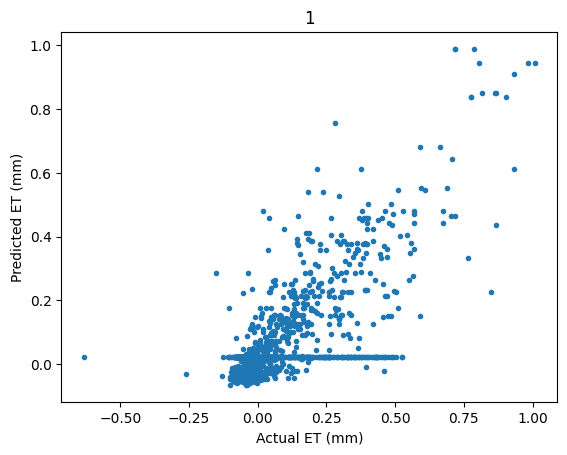

<Figure size 640x480 with 0 Axes>

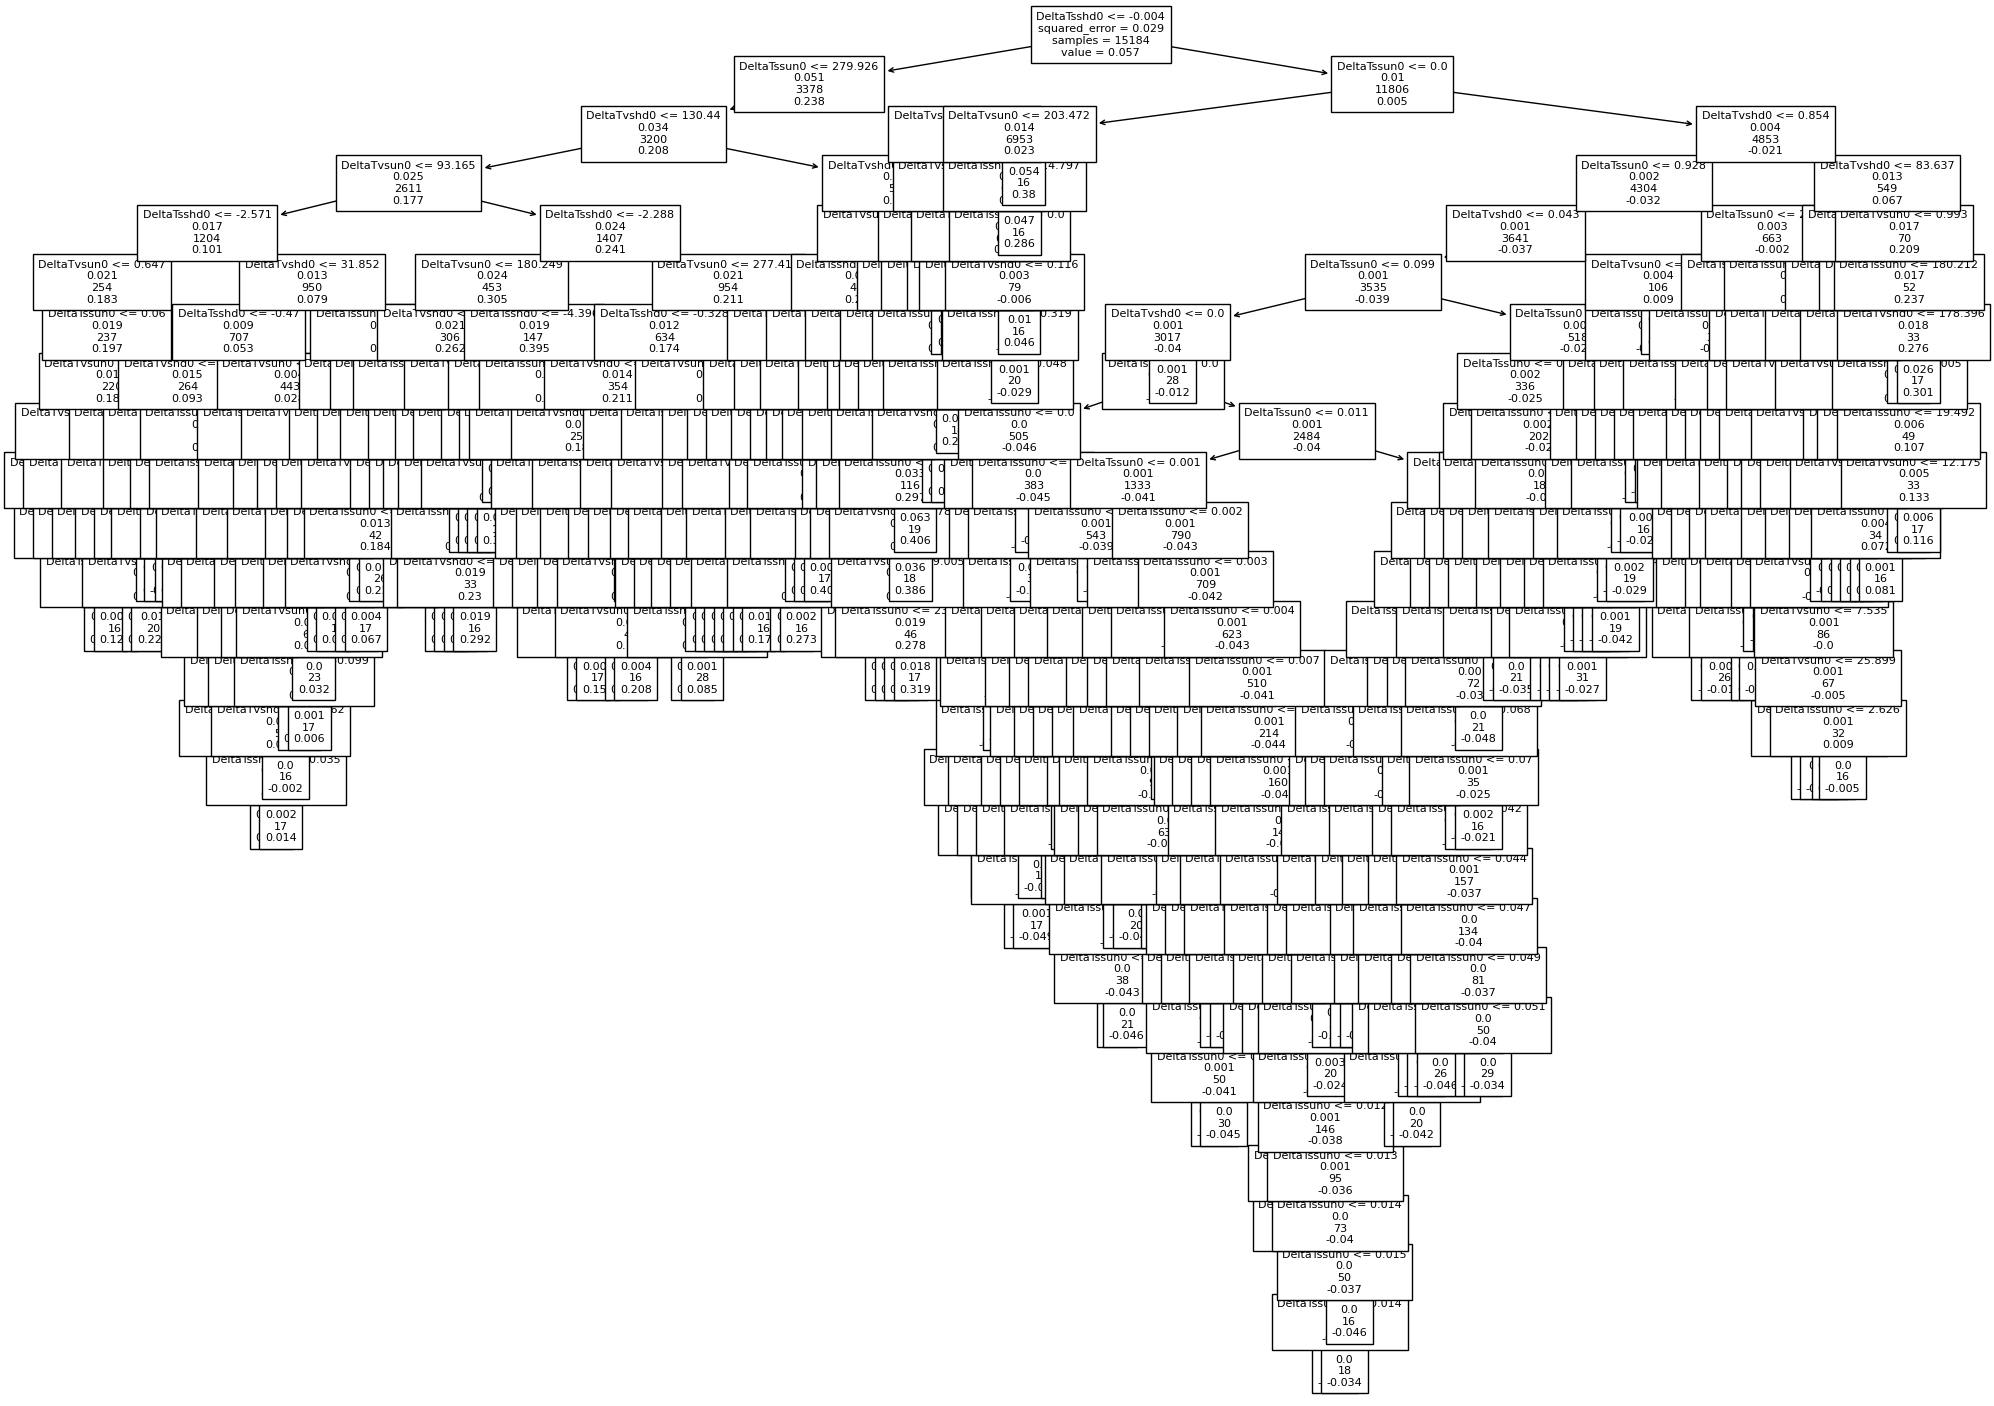

Best parameter (CV score=0.672):
{'min_samples_leaf': 0.001, 'min_samples_split': 0.001}
(7592, 48) (7592, 9)


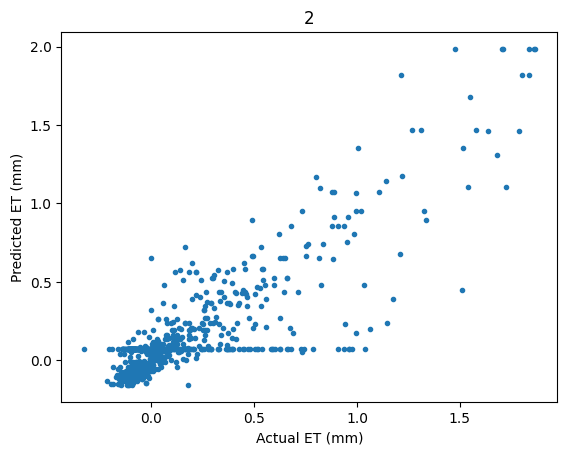

<Figure size 640x480 with 0 Axes>

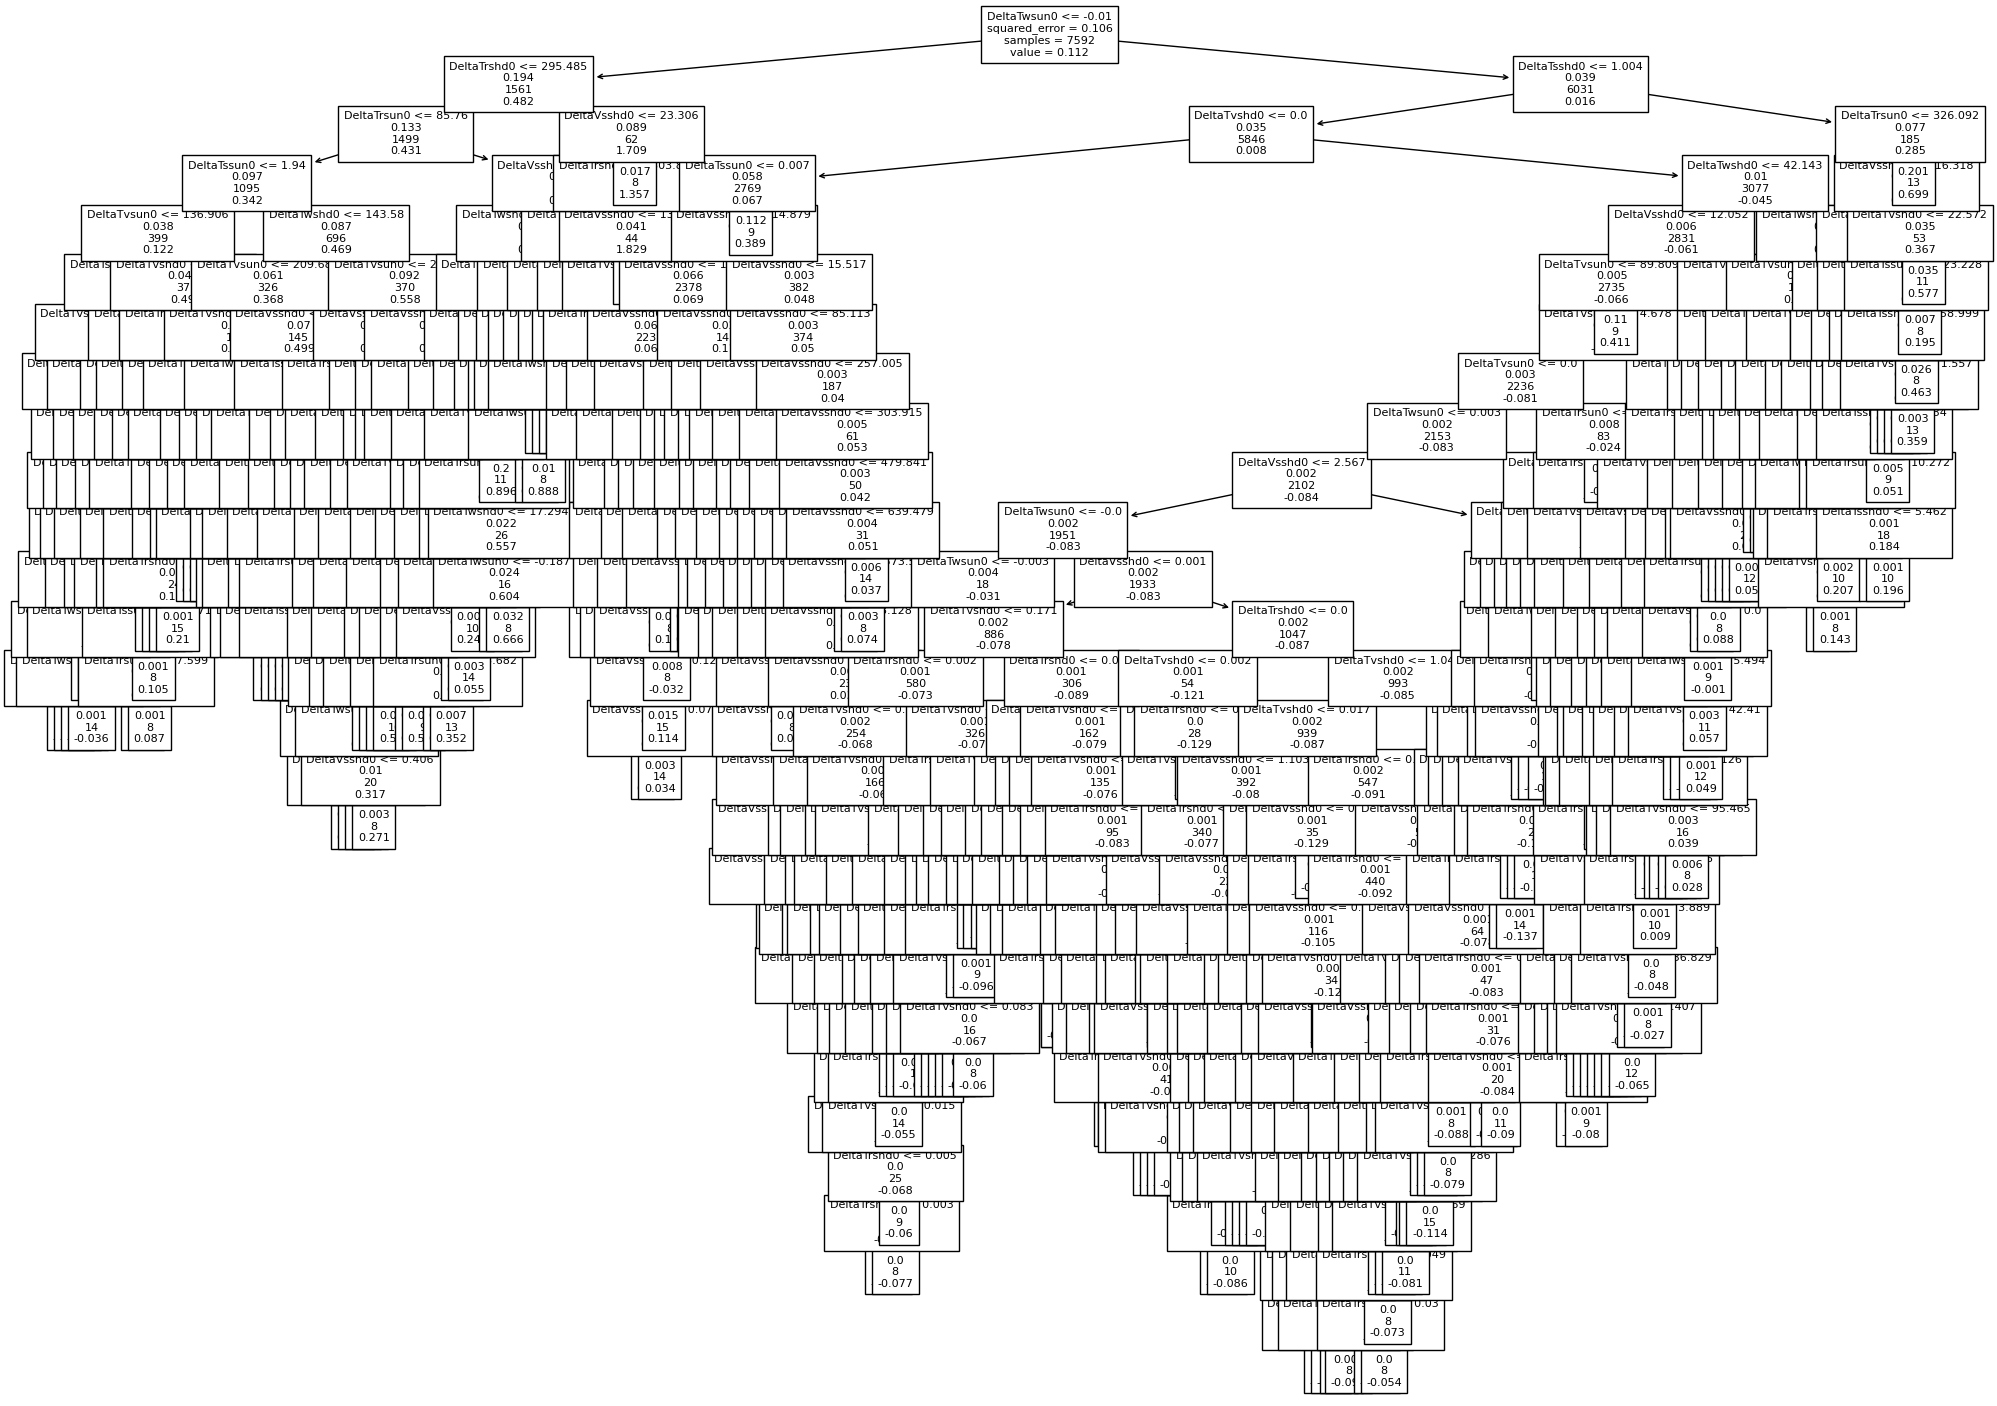

Best parameter (CV score=0.678):
{'min_samples_leaf': 0.001, 'min_samples_split': 0.01}
(5061, 72) (5061, 13)


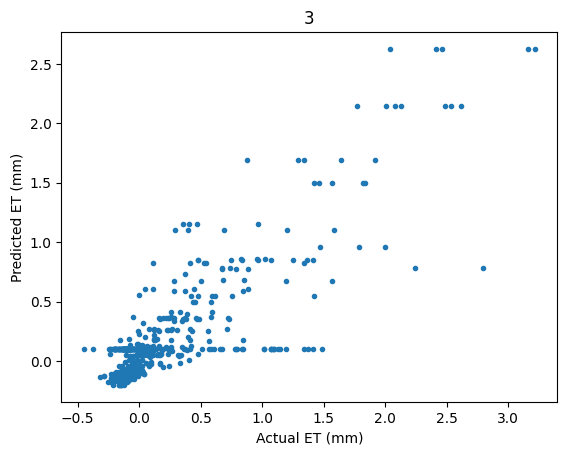

<Figure size 640x480 with 0 Axes>

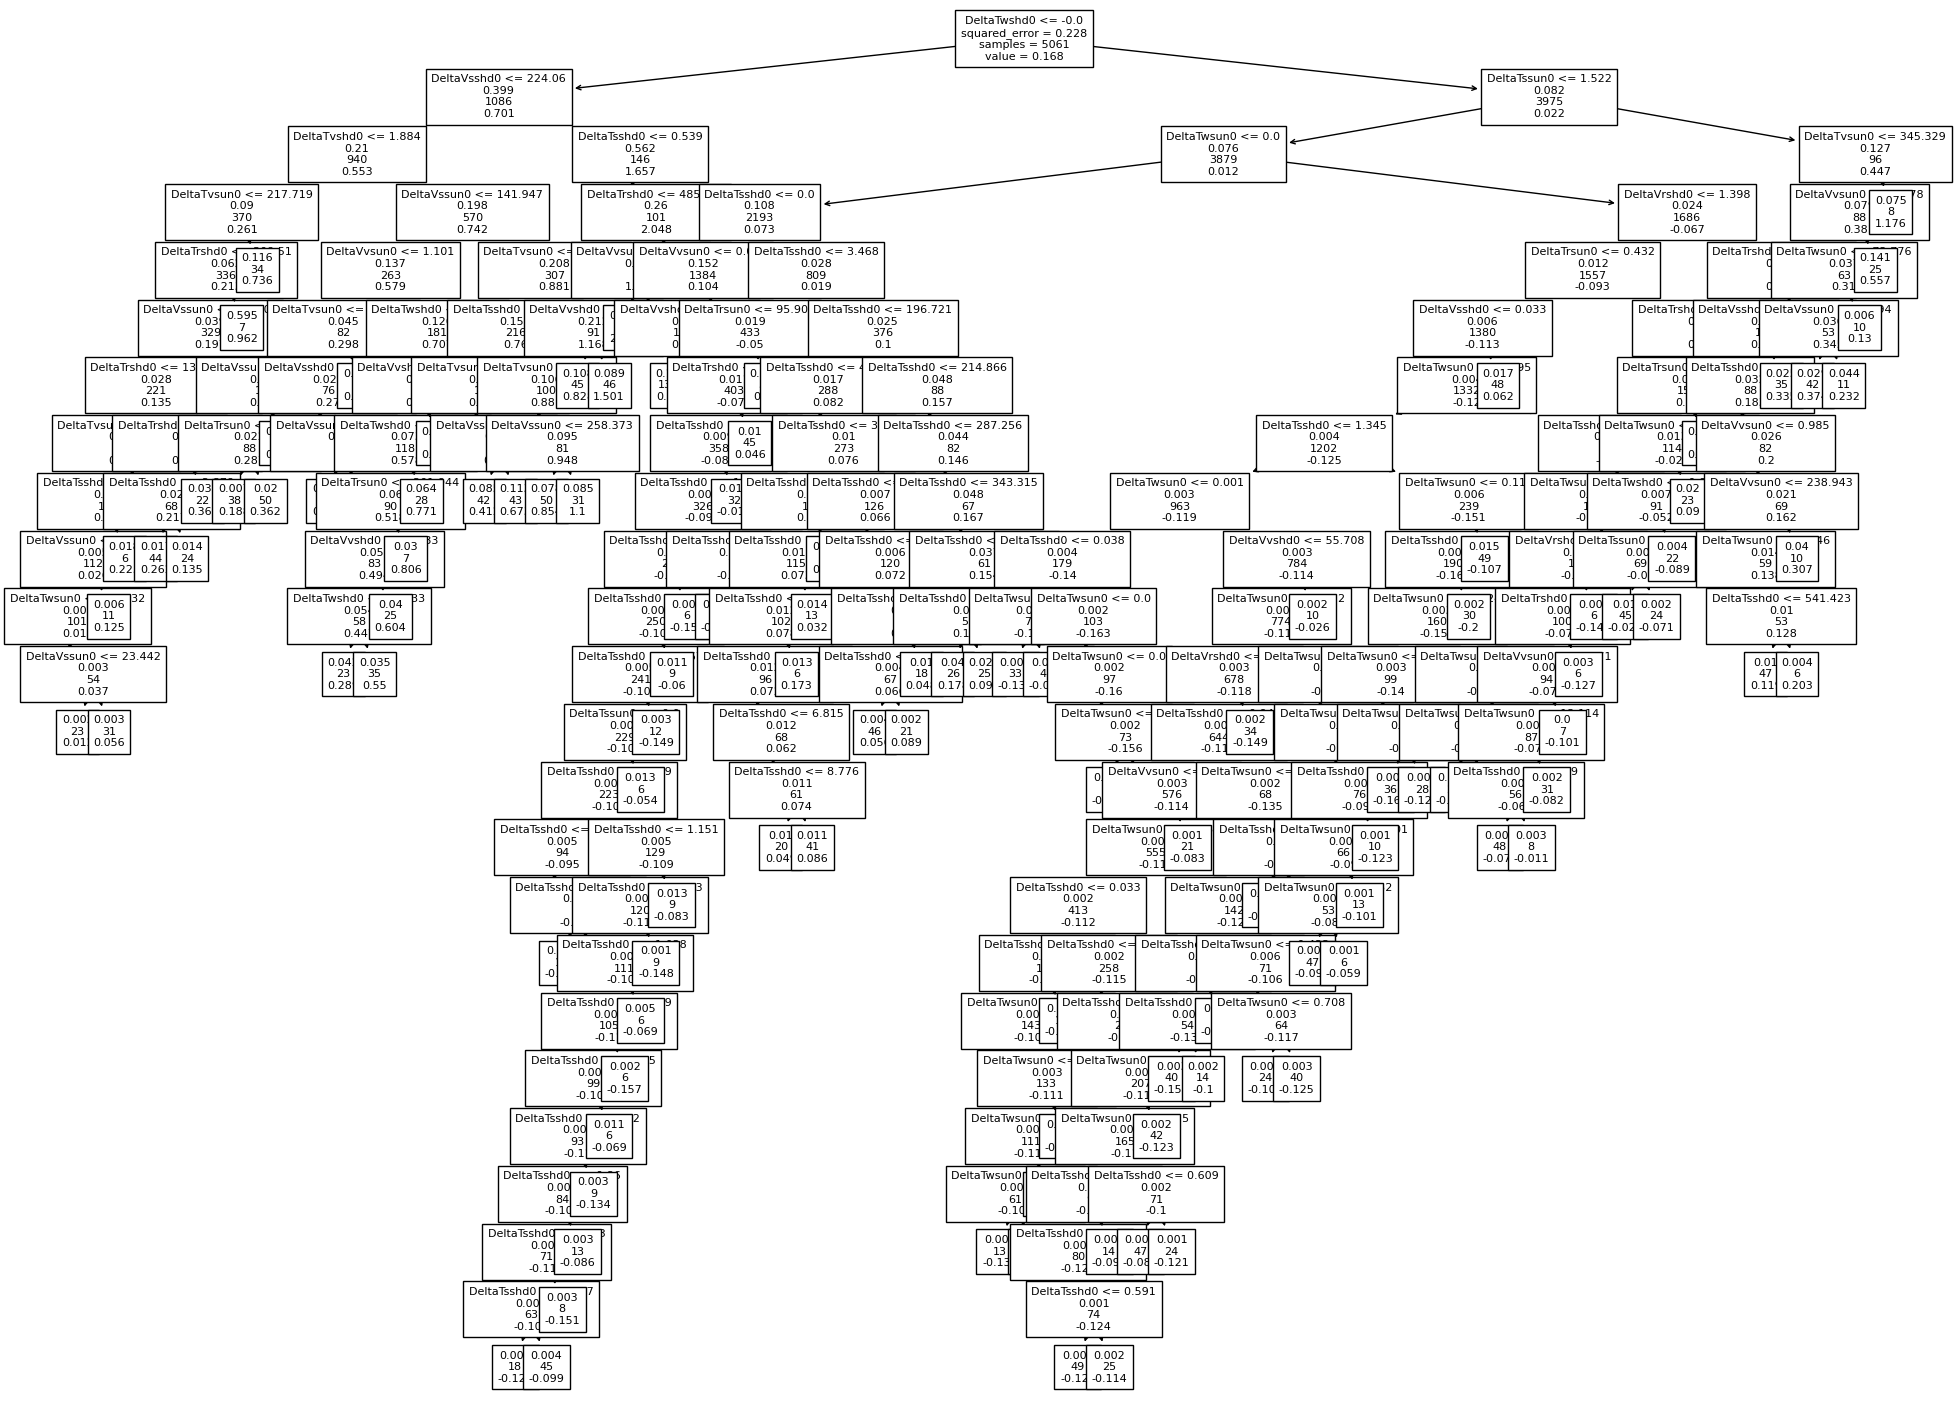

Best parameter (CV score=0.678):
{'min_samples_leaf': 0.001, 'min_samples_split': 0.01}
(3796, 96) (3796, 13)


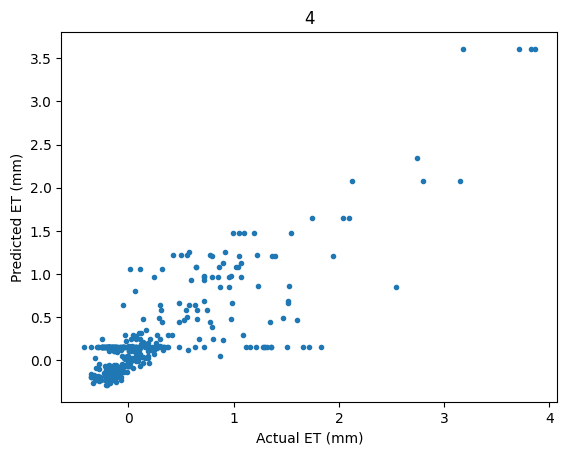

<Figure size 640x480 with 0 Axes>

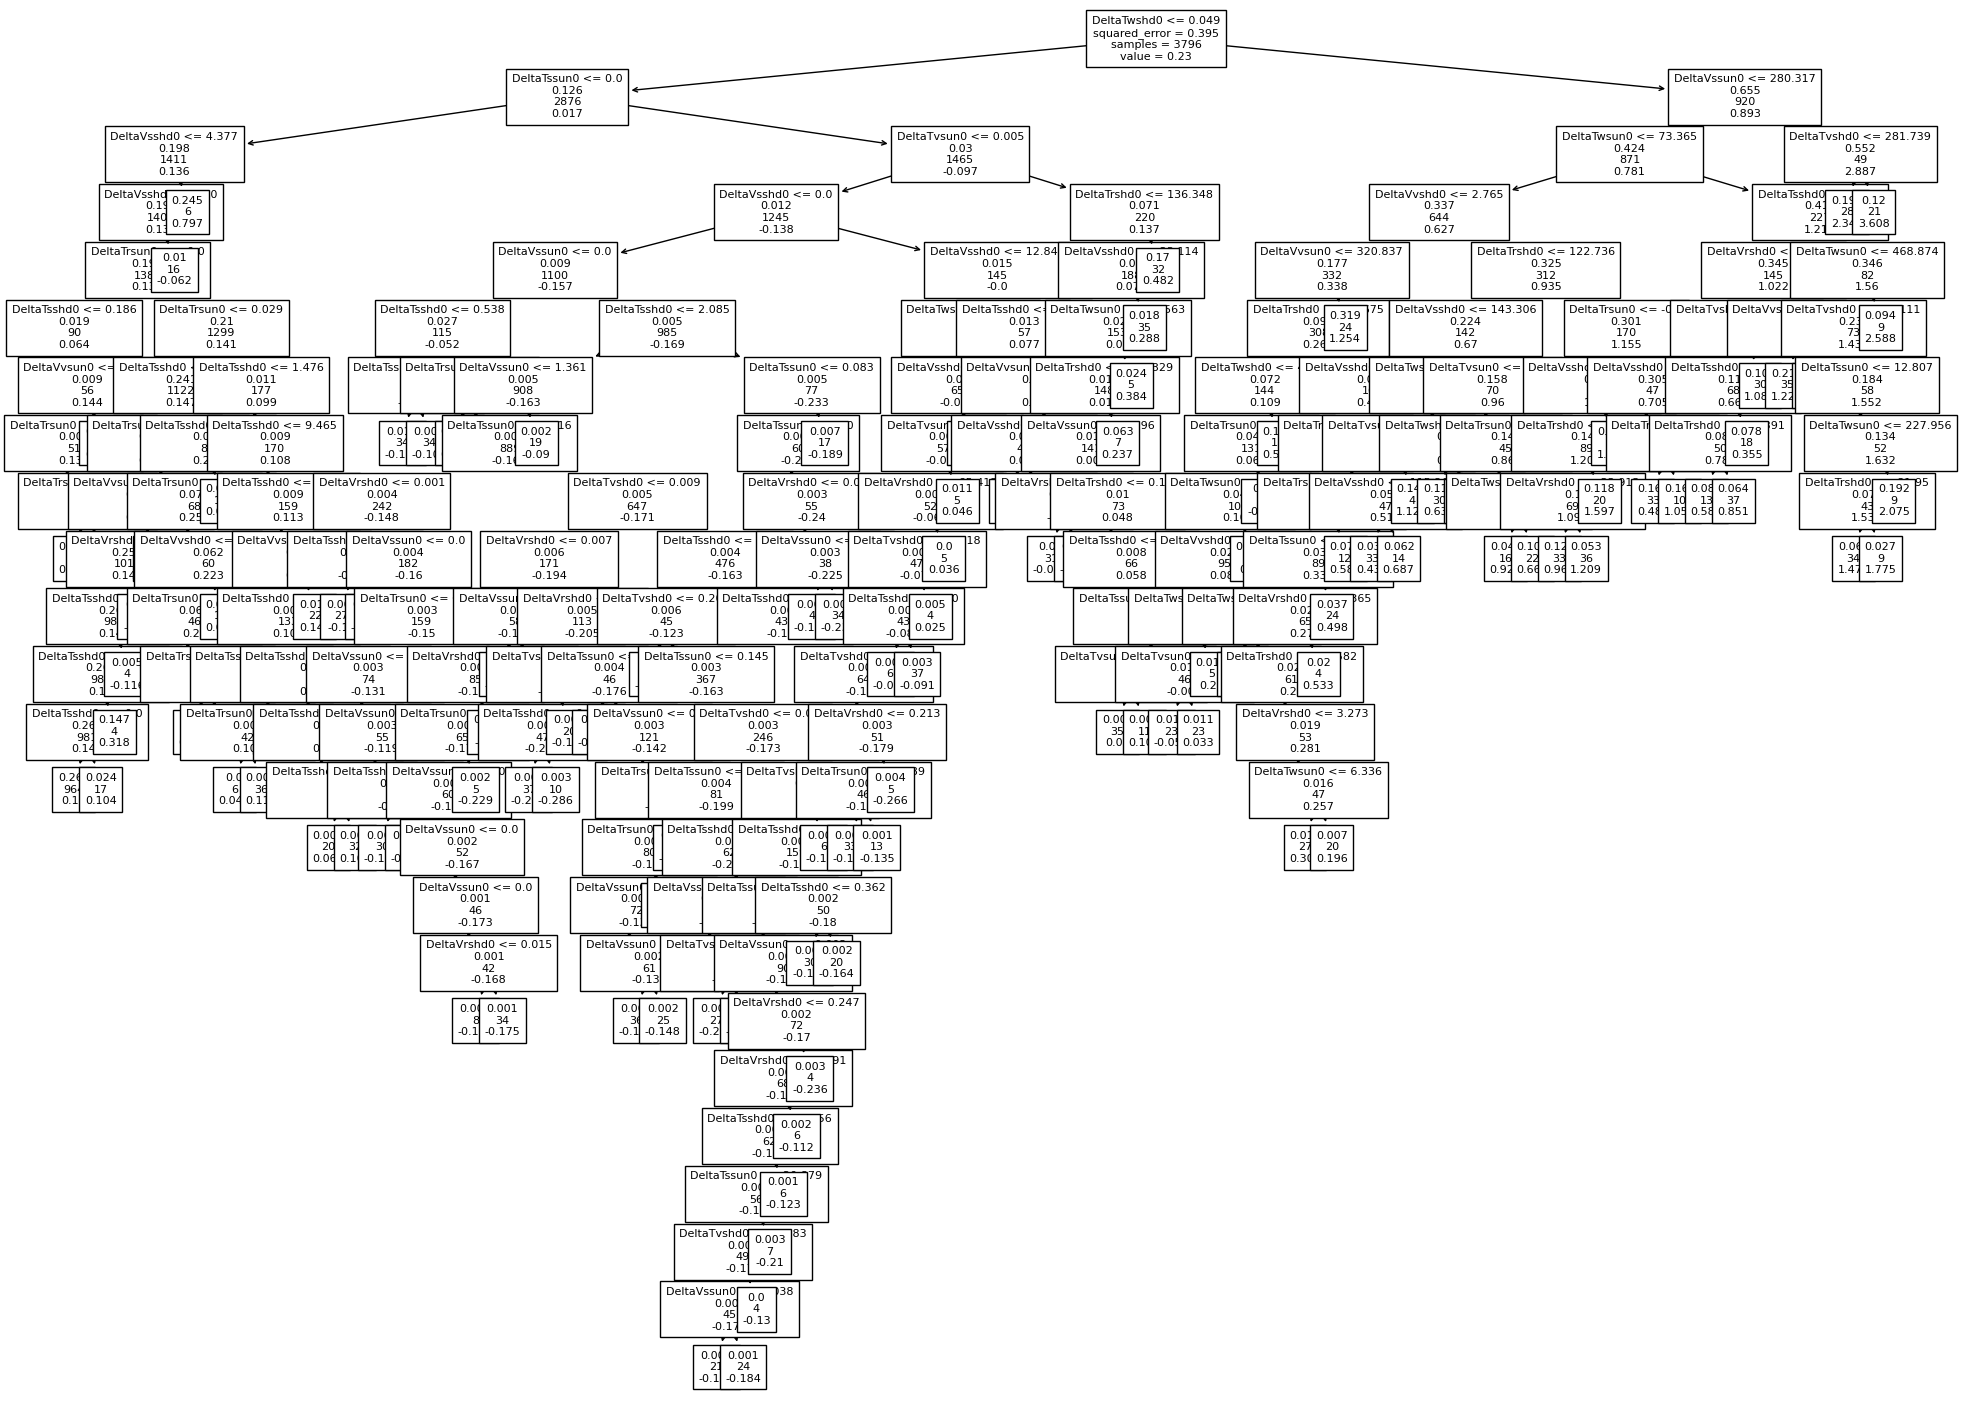

Best parameter (CV score=0.667):
{'min_samples_leaf': 0.01, 'min_samples_split': 0.01}
(2530, 144) (2530, 11)


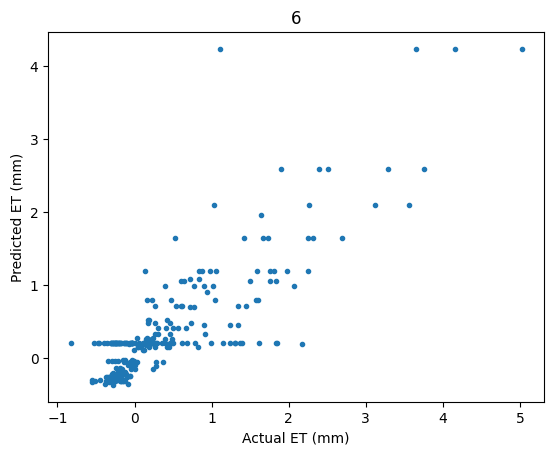

<Figure size 640x480 with 0 Axes>

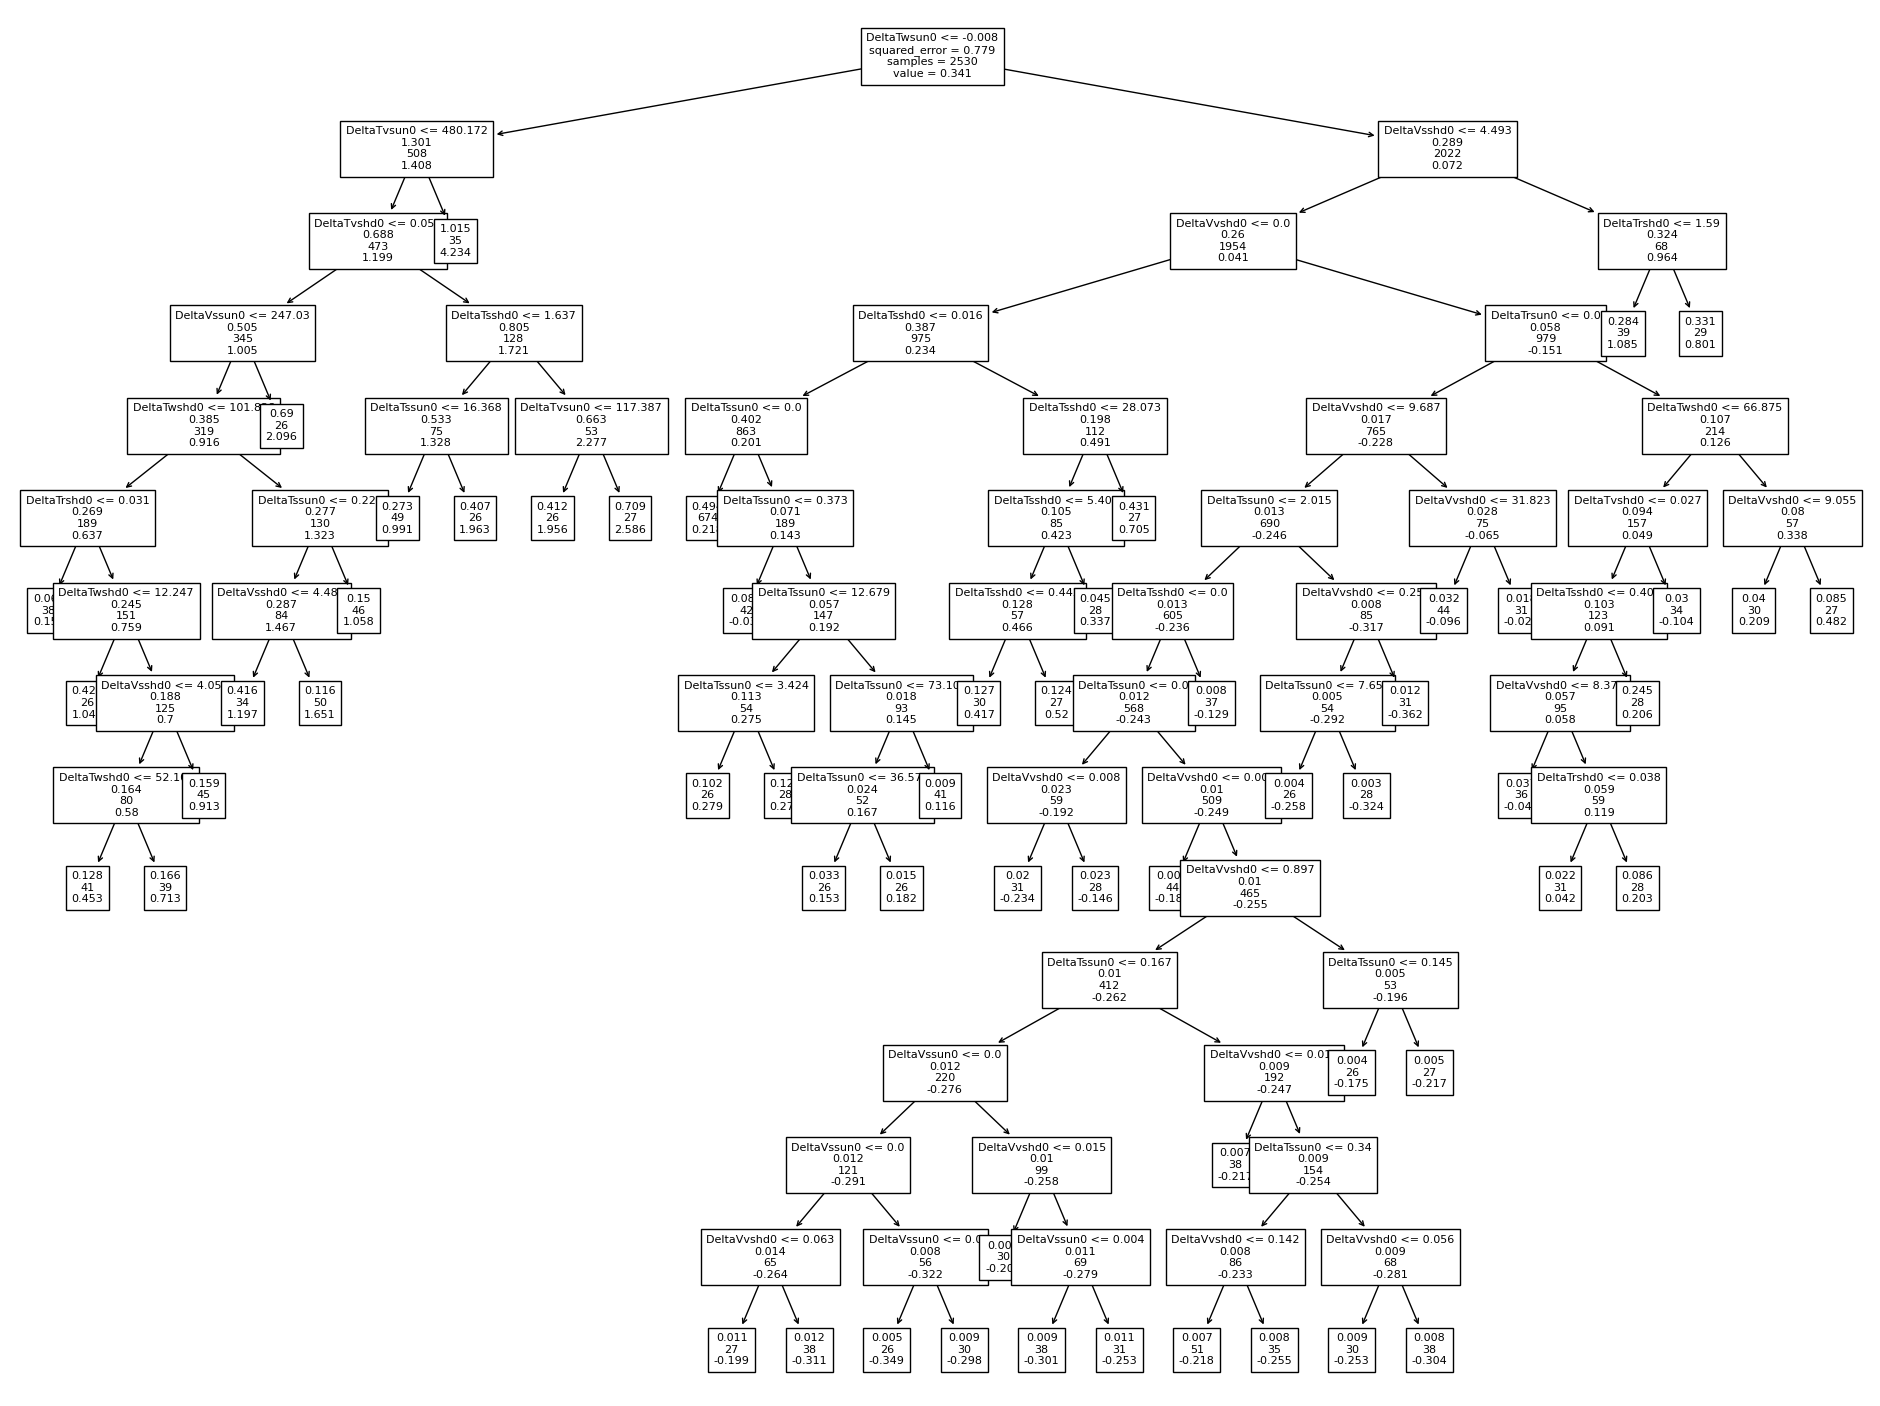

<Figure size 640x480 with 0 Axes>

In [34]:
n_feats = len(inputs)
best_scores = []
for period_length in [1,2,3,4,6]:
    feature_names = []
    batched_flux = daily_flux[[*inputs]].values.reshape([-1,period_length*n_feats])
    batched_et = daily_flux[['ET']].values.reshape([-1,period_length])
    for k in range(period_length):
        for inp in inputs:
            feature_names.append(inp+str(k))
    n_batches = batched_flux.shape[0]
    n_train = int(0.9*n_batches)
    n_test = n_batches-n_train
    batches = np.arange(n_batches)
    np.random.shuffle(batches)
    train = batches[0:n_train]
    test = batches[n_train:]
    batches_train_et,batches_train_feats = np.sum(batched_et[train,:],axis=1),batched_flux[train,0:period_length*n_feats] 
    batches_test_et,batches_test_feats =  np.sum(batched_et[test,:],axis=1),batched_flux[test,0:period_length*n_feats] 
    batches_train_et.shape
    
    cart = DecisionTreeRegressor()
        
    cart.fit(batches_train_feats, batches_train_et)

    parameters = {'min_samples_split':[0.001,0.01,0.1],'min_samples_leaf':[0.001,0.01,0.1]}
        
    search = GridSearchCV(cart, parameters,n_jobs=-1,cv=10,verbose=0)
    
    search.fit(batches_train_feats, batches_train_et)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)
    #pred = search.predict(batches_test_feats)
    drt = search.best_estimator_
    
    model = SelectFromModel(drt, prefit=True)
    batches_train_feats_new = model.transform(batches_train_feats)
    batches_test_feats_new = model.transform(batches_test_feats)
    print(batches_train_feats.shape,batches_train_feats_new.shape)

    drt = DecisionTreeRegressor(min_samples_leaf = drt.min_samples_leaf,min_samples_split = drt.min_samples_split)
    drt.fit(batches_train_feats_new,batches_train_et)
    pred = drt.predict(batches_test_feats_new)
    
    pipeline = Pipeline(steps=[("selector", model), ("drt", drt)])#

    filename = os.path.join(p3,'et_dtr_pipeline_'+str(period_length)+'_final.pk.sav')
    with open(filename, 'wb') as f:  # Python 3: open(..., 'wb'
        pickle.dump(pipeline, f)

    n_param = 2*drt.tree_.n_leaves+drt.tree_.node_count

    best_scores.append([mean_squared_error(pred,batches_test_et)/period_length,
                        r2_score(pred,batches_test_et),period_length,n_param,n_train])
    plt.plot(batches_test_et,pred,'.',)
    plt.title(str(period_length))
    plt.ylabel('Predicted ET (mm)')
    plt.xlabel('Actual ET (mm)')
    plt.show()
    plt.savefig(p4+'/'+'performance_drt_'+str(period_length)+'_'+datestr+'.png',dpi=300)
    plt.clf()
    # plot tree
    plt.show()
    plt.figure(figsize=[24,18])
    plot_tree(drt,feature_names=feature_names,fontsize=8,label='root')
    plt.savefig(p4+'/'+'tree_drt_'+str(period_length)+'_'+datestr+'.png',dpi=300)
    plt.show()
    plt.clf()

Text(0.5, 0, 'MSE (mm2)')

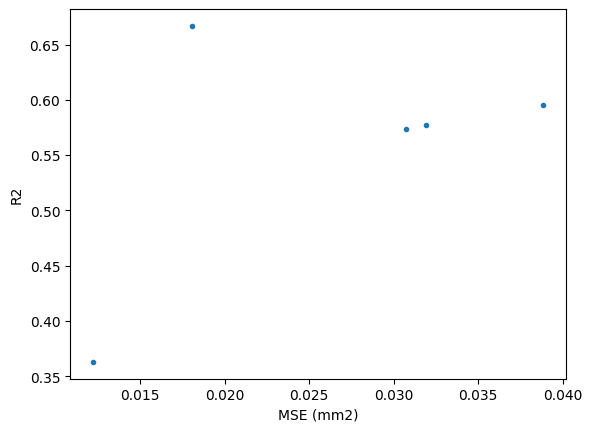

In [35]:
plt.plot(np.array(best_scores)[:,0],np.array(best_scores)[:,1],'.')
plt.ylabel('R2')
plt.xlabel('MSE (mm2)')

In [36]:
pd.DataFrame(np.array(best_scores),columns=['MSE (mm2)','R2','Period','n_params','n_train']).to_csv(p3+'/'+'drt_results_'+datestr+'.csv')